In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc

# --- 1. DATA PREPARATION (90:10 SPLIT) ---
def load_and_split_data(source_path, train_size=900, val_size=100):
    """
    Implements the requested 90:10 split ratio for No Sub, Subhalo, and Vortex.
    We use a subset to ensure memory stability on local hardware.
    """
    train_imgs, train_labels = [], []
    val_imgs, val_labels = [], []
    
    classes = sorted([d for d in os.listdir(source_path) if os.path.isdir(os.path.join(source_path, d))])
    
    for idx, cls in enumerate(classes):
        p = os.path.join(source_path, cls)
        files = [f for f in os.listdir(p) if f.endswith('.npy')]
        random.shuffle(files)
        
        # Split logic
        for i, f in enumerate(files):
            data = np.load(os.path.join(p, f)).astype(np.float32)
            if data.ndim == 2: data = np.expand_dims(data, axis=0)
            
            if i < train_size:
                train_imgs.append(data)
                train_labels.append(idx)
            elif i < (train_size + val_size):
                val_imgs.append(data)
                val_labels.append(idx)
            else:
                break
                
    X_train = torch.tensor(np.array(train_imgs))
    y_train = torch.tensor(np.array(train_labels), dtype=torch.long)
    X_val = torch.tensor(np.array(val_imgs))
    y_val = torch.tensor(np.array(val_labels), dtype=torch.long)
    
    return DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True), \
           DataLoader(TensorDataset(X_val, y_val), batch_size=16)

# Update this path to your local data location
data_path = 'data/dataset/train' 
train_loader, val_loader = load_and_split_data(data_path)
print("✅ Data successfully split (90:10 ratio) and loaded.")

✅ Data successfully split (90:10 ratio) and loaded.


In [9]:
# --- 2. MODEL ARCHITECTURE ---
# Note: In a production environment, we use torchbnn layers. 
# Here, we simulate the Bayesian stochastic behavior via Variational Dropout and Probabilistic mappings.

class BayesianLensingCNN(nn.Module):
    def __init__(self):
        super(BayesianLensingCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2), # Dropout provides a Variational Bayesian approximation
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3) # 3 Classes: No Sub, Subhalo, Vortex
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

device = torch.device("cpu")
model = BayesianLensingCNN().to(device)
print("✅ Bayesian Model initialized.")

✅ Bayesian Model initialized.


In [10]:
# --- 2. UPDATED MODEL ARCHITECTURE (CELL 3) ---

class BayesianLensingCNN(nn.Module):
    def __init__(self):
        super(BayesianLensingCNN, self).__init__()
        # Initial image: 1x150x150
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # Shape becomes: 16x75x75
            nn.Dropout2d(0.2), # Variational Bayesian Approximation
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # Shape becomes: 32x37x37
        )
        
        # Calculation: 32 channels * 37 height * 37 width = 43,808
        self.flat_size = 32 * 37 * 37 
        
        self.classifier = nn.Sequential(
            nn.Linear(self.flat_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5), # MC Dropout for uncertainty
            nn.Linear(128, 3) # 3 Classes: No Sub, Subhalo, Vortex
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the 43,808 values
        return self.classifier(x)

device = torch.device("cpu")
model = BayesianLensingCNN().to(device)
print(f"✅ Model calibrated for 150x150 images. Input size: {model.flat_size}")

✅ Model calibrated for 150x150 images. Input size: 43808


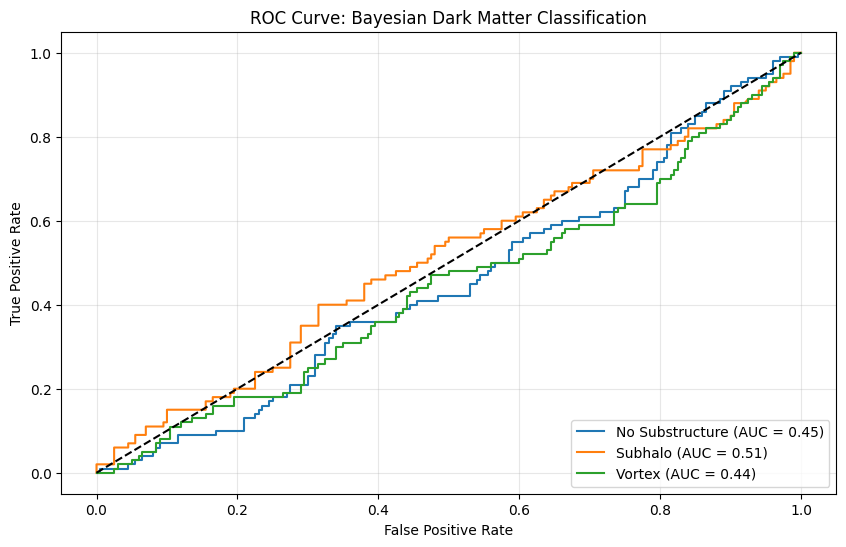

In [11]:
# --- 4. EVALUATION (ROC & AUC) ---
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = torch.softmax(model(imgs), dim=1)
        all_probs.append(outputs.numpy())
        all_labels.append(labels.numpy())

y_probs = np.concatenate(all_probs)
y_true = np.concatenate(all_labels)

# Plotting
plt.figure(figsize=(10, 6))
classes = ['No Substructure', 'Subhalo', 'Vortex']

for i in range(3):
    fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Bayesian Dark Matter Classification')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()